In [2]:
import random, torch
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
  

Tesla T4


In [3]:
import math
import os
import re
import time
import pickle

from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output


In [4]:
DATA_PATH_CLOUD = '/content/gdrive/MyDrive/DS/DFC/data/'

# mounting folder from google drive         
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Подготовка данных

In [5]:
# Загружаем исходные данные из паркет-файла и выполняем небольшую предобработку
def replace_re(text, regexp, inplace): 
    return regexp.sub(inplace, text)

use_threads=False
data = pd.read_parquet(DATA_PATH_CLOUD + "data_fusion_train.parquet", columns=['item_name', 'category_id'])
regex_punc = re.compile('[%s]'%re.escape('!?'))
data['item_name'] = data['item_name'].apply(lambda x: replace_re(x, regex_punc, ' '))
data['item_name'] = data['item_name'].apply(lambda x: x.strip())
regex_seq_spaces = re.compile(' {2,}')
data['item_name'] = data['item_name'].apply(lambda x: replace_re(x, regex_seq_spaces, ' '))
data['item_name'] = data['item_name'].apply(lambda x: x.lower())
data = data[data.category_id != -1].drop_duplicates('item_name')

In [6]:
data.head()

,item_name,category_id
1,"молоко 3,2%,шт",78
3,"компот из изюма, 114 ккал",71
4,"макаронные изделия отварные (масло сливочное),...",71
17,кофе капучино большой эден 18,70
40,хлеб на сыворотке 350г,84


In [7]:
# Загружаем данные с псевдо разметкой
# Предобработка не выполняется, т.к. item_name c псевдо разметкой уже предобработаны
df_pseudo = pd.read_csv(DATA_PATH_CLOUD + "pseudo.csv", lineterminator='\n')
df_pseudo.columns = ['item_name',	'category_id']
df_pseudo = df_pseudo.dropna(subset=['category_id'])

In [8]:
df_pseudo.head()

,item_name,category_id
0,merci шок мол лес орех/минд100г,84
1,"лимонад ""грейпфрут"" 0 5л (стекло)",83
2,свекла с кальм в майон 1 кг,71
3,1 капотен таб 25мг №40bristol-myer,38
4,пена монтажная профессиональная kudo всесез ho...,114


In [9]:
df_pseudo.shape

(107503, 2)

In [10]:
cols = ["item_name", "category_id"]
united_df = pd.concat(
    [data[cols],
     df_pseudo[cols]],
      ignore_index=True
     )
united_df = united_df.dropna(subset=['category_id']).drop_duplicates('item_name')

In [11]:
united_df.shape

(155394, 2)

#Обучение Catboost

In [12]:
!pip3 install catboost

In [13]:
from catboost import Pool, CatBoostClassifier

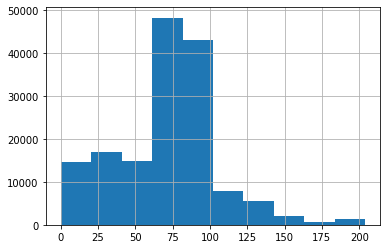

In [14]:
united_df['category_id'].hist()

In [17]:
text_features = ['item_name']
target = 'category_id'

In [18]:
def create_features(data):
    data['first'] = data['item_name'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else 'none')
    data['last'] = data['item_name'].apply(lambda x: x.split()[-1] if len(x.split()) > 0 else 'none')
    data['is_preservativ'] = data.item_name.apply(lambda x: int('презерватив' in x.lower()))
    data['is_auto'] = data.item_name.apply(lambda x: int('авто' in x.lower() or \
                                                            'щетк' in x.lower() or \
                                                             'сантиметр' in x.lower()))

    data['is_paper'] = data.item_name.apply(lambda x: int('бумага' in x.lower()))
    data['is_otkritka'] = data.item_name.apply(lambda x: int('открытка' in x.lower()))
    data['is_born'] = data.item_name.apply(lambda x: int('рождения' in x.lower()))
    data['is_a4'] = data.item_name.apply(lambda x: int('а4' in x.lower()))
    data['is_ubiley'] = data.item_name.apply(lambda x: int('юбиле' in x.lower()))

    #24
    data['is_list'] = data.item_name.apply(lambda x: int('лист' in x.lower()))
    data['is_kanc'] = data.item_name.apply(lambda x: int('канцелярский' in x.lower()))
    data['is_dnevnik'] = data.item_name.apply(lambda x: int('дневник' in x.lower()))
    
    data['second_last_word'] = data.item_name.apply(lambda x: x.split()[-2] if len(x.split()) > 1 else 'none')
    data['second_first_word'] = data.item_name.apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'none')

    data['first_word_len'] = data['first'].apply(len)
    data['last_word_len'] = data['last'].apply(len)

    data['item_name_len'] = data.item_name.apply(lambda x: len(x.split()))

    data['last_first_word'] = data['last'] + data['first']
    return data

In [22]:
import nltk
import string
from nltk.tokenize import WordPunctTokenizer 

In [24]:
#подготовка к препроцессингу

nltk.download('punkt', download_dir='nltk_models')
nltk.download('stopwords', download_dir='nltk_models')
!git clone https://github.com/natasha/razdel.git
!pip uninstall -y razdel
!pip3 install razdel

[nltk_data] Downloading package punkt to nltk_models...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to nltk_models...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
from razdel import tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
RU_STOP_WORDS = set(stopwords.words('russian'))

# def prepare(token):
#      return re.sub("[^0-9A-Za-zА-Яа-я ]", "", token)
    

def pre_process(text):
    return " ".join([token.lower() for token in [_.text for _ in tokenize(text)]
                     if (token not in RU_STOP_WORDS) or (token not in string.punctuation)])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
# train['item_name_tmp'] = train['item_name'].values
# valid['item_name_tmp'] = valid['item_name'].values

# train['item_name'] = train.item_name.apply(pre_process)
# valid['item_name'] = valid.item_name.apply(pre_process)

def replace_re(text, regexp, inplace): 
    return regexp.sub(inplace, text)
    
regex_punc = re.compile('[%s]'%re.escape('.,!?'))
united_df['item_name'] = united_df['item_name'].apply(lambda x: replace_re(x, regex_punc, ' '))
regex_seq_spaces = re.compile(' {2,}')
united_df['item_name'] = united_df['item_name'].apply(lambda x: x.strip())
united_df['item_name'] = united_df['item_name'].apply(lambda x: replace_re(x, regex_seq_spaces, ' '))
united_df['item_name'] = united_df['item_name'].apply(lambda x: x.lower())

united_df['item_name'] = united_df['item_name'].apply(lambda x: pre_process(x))

In [51]:
train, valid = train_test_split(united_df,
                                                test_size=0.10, 
                                                stratify=united_df['category_id'], 
                                                shuffle=True, random_state=42)

train.shape, valid.shape

((139854, 2), (15540, 2))

In [52]:
train = create_features(train)
valid = create_features(valid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [53]:
model = CatBoostClassifier(
    text_features=text_features,
    verbose=50,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    task_type="GPU",
    iterations=1000,
    learning_rate=0.2,      
#     reg_lambda=0.0001,
    
    text_processing = {
        "tokenizers" : [{
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "delimiter" : " "
        }],

        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "token_level_type": "Letter",
            "max_dictionary_size" : "150000",
            "occurrence_lower_bound" : "1",
            "gram_order" : "2"
        },{
            "dictionary_id" : "Trigram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "3"
        },{
            "dictionary_id" : "Fourgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "4"
        },{
            "dictionary_id" : "Fivegram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "5"
        },{
            "dictionary_id" : "Sixgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "6"
        }
        ],

        "feature_processing" : {
            "default" : [
                    {
                    "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                    "feature_calcers" : ["BoW"],
                    "tokenizers_names" : ["Space"]
                },
                    {
                "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            },{
                "dictionaries_names" : [ "BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["BM25"],
                "tokenizers_names" : ["Space"]
            },
            ],
        }
    }
)



In [55]:
feature_names = [
                 'item_name',
                 'first',
                 'last', 'is_preservativ', 'is_paper', 'is_otkritka', 'is_born', 'is_a4', 'is_ubiley',                                         
                 'is_auto', 'is_list', 'is_kanc', 'is_dnevnik',
                'first_word_len', 'last_word_len',
                 'second_last_word', 'second_first_word',
                 'last_first_word',
                ] 


In [56]:
valid[feature_names]

,item_name,first,last,is_preservativ,is_paper,is_otkritka,is_born,is_a4,is_ubiley,is_auto,is_list,is_kanc,is_dnevnik,first_word_len,last_word_len,second_last_word,second_first_word,last_first_word
1417,оладьи 1 шт,оладьи,шт,0,0,0,0,0,0,0,0,0,0,6,2,1,1,штоладьи
75615,масло миладора подсолнечное 0 9 л,масло,л,0,0,0,0,0,0,0,0,0,0,5,1,9,миладора,лмасло
30143,ggtt 01_1-p 0 104 футболка для девочек girl ' ...,ggtt,104,0,0,0,0,0,0,0,0,0,0,4,3,р,01_1-p,104ggtt
146933,сигареты eve premium purple - мрц- 140 00 р,сигареты,р,0,0,0,0,0,0,0,0,0,0,8,1,00,eve,рсигареты
139193,мешок п / п зеленый 55 * 95 см,мешок,см,0,0,0,0,0,0,0,0,0,0,5,2,95,п,сммешок
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34915,средство sally hansen для укре,средство,укре,0,0,0,0,0,0,0,0,0,0,8,4,для,sally,укресредство
128015,сосиски дмитрогорские в п / а газ ( 1 кг ) дг,сосиски,дг,0,0,0,0,0,0,0,0,0,0,7,2,),дмитрогорские,дгсосиски
148667,минтай жареный 100 гр статус,минтай,статус,0,0,0,0,0,0,0,0,0,0,6,6,гр,жареный,статусминтай
30054,1/1 салфетки влажные детские памперино n 15 ал...,1/1,чай,0,0,0,0,0,0,0,0,0,0,3,3,вера-зеленый,салфетки,чай1/1


In [57]:
train[feature_names]

,item_name,first,last,is_preservativ,is_paper,is_otkritka,is_born,is_a4,is_ubiley,is_auto,is_list,is_kanc,is_dnevnik,first_word_len,last_word_len,second_last_word,second_first_word,last_first_word
16523,хек жареный кг,хек,кг,0,0,0,0,0,0,0,0,0,0,3,2,жареный,жареный,кгхек
89237,салат цезарь с курой б / л,салат,л,0,0,0,0,0,0,0,0,0,0,5,1,/,цезарь,лсалат
39712,напиток б / а фанта 330 мл ж / б /,напиток,/,0,0,0,0,0,0,0,0,0,0,7,1,б,б,/напиток
73644,джинсы ( s 011 34 59 d 1 ),джинсы,),0,0,0,0,0,0,0,0,0,0,6,1,1,(,)джинсы
131922,джинсы ( d 013 34 59 d 0 ),джинсы,),0,0,0,0,0,0,0,0,0,0,6,1,0,(,)джинсы
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99321,кофе 3 в 1 мягкий нескафе 0 16 гр,кофе,гр,0,0,0,0,0,0,0,0,0,0,4,2,16,3,гркофе
63090,батон к чаю 300 гр хлебокомбинат,батон,хлебокомбинат,0,0,0,0,0,0,0,0,0,0,5,13,гр,к,хлебокомбинатбатон
15083,биг мак бекон бкомбо,биг,бкомбо,0,0,0,0,0,0,0,0,0,0,3,6,бекон,мак,бкомбобиг
77230,ом тальолини алио-олио с креветками,ом,креветками,0,0,0,0,0,0,0,0,0,0,2,10,с,тальолини,креветкамиом


In [60]:
model.fit(
    train[text_features], train[target],
    eval_set=(valid[text_features], valid[target]),
)

0:	learn: 0.5038827	test: 0.5092648	best: 0.5092648 (0)	total: 1.29s	remaining: 21m 28s
50:	learn: 0.8795186	test: 0.8967109	best: 0.8967109 (50)	total: 1m 5s	remaining: 20m 22s
100:	learn: 0.8908739	test: 0.9055142	best: 0.9055142 (100)	total: 2m 11s	remaining: 19m 32s
150:	learn: 0.9005029	test: 0.9108063	best: 0.9108610 (147)	total: 3m 18s	remaining: 18m 38s
200:	learn: 0.9053714	test: 0.9134086	best: 0.9134086 (200)	total: 4m 24s	remaining: 17m 32s
250:	learn: 0.9114259	test: 0.9156275	best: 0.9156275 (250)	total: 5m 31s	remaining: 16m 29s
300:	learn: 0.9159170	test: 0.9181474	best: 0.9181474 (300)	total: 6m 37s	remaining: 15m 22s
350:	learn: 0.9205488	test: 0.9187124	best: 0.9191882 (337)	total: 7m 40s	remaining: 14m 12s
400:	learn: 0.9241499	test: 0.9198181	best: 0.9198727 (399)	total: 8m 43s	remaining: 13m 1s
450:	learn: 0.9275885	test: 0.9209105	best: 0.9209105 (450)	total: 9m 45s	remaining: 11m 53s
500:	learn: 0.9310363	test: 0.9213918	best: 0.9216684 (465)	total: 10m 50s	rema

# Расчет метрик

In [63]:
print(f'f1_score_test: {f1_score(valid[target], model.predict(valid[text_features]), average="weighted")}')

f1_score_test: 0.9254668649296225


In [75]:
print(classification_report(valid[target], model.predict(valid[text_features])))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1025
           1       1.00      0.93      0.96        14
           2       1.00      1.00      1.00       254
           3       1.00      0.94      0.97        18
           4       0.94      0.87      0.91        39
           6       1.00      0.14      0.25         7
           7       0.96      0.96      0.96        25
           9       1.00      0.91      0.95        11
          11       0.50      0.40      0.44         5
          12       0.88      0.95      0.91        38
          13       0.86      1.00      0.92        12
          19       1.00      0.56      0.71         9
          20       1.00      0.67      0.80        12
          24       0.86      0.50      0.63        12
          26       0.00      0.00      0.00         2
          27       1.00      0.92      0.96        12
          29       0.98      0.95      0.96        55
          30       0.79    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
    with open(DATA_PATH_CLOUD + "catboost.clf", 'rb') as fout:
        clf = pickle.loads(fout.read())